<a href="https://colab.research.google.com/github/Simon-creator-jara/Inteligencia_artificial/blob/main/Deep_Learning_Autoencoder_Reducci%C3%B3n_Dimensionalidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders Reducción de dimensionalidad
## Cargar datos

In [ ]:
!mkdir MNISTMedicalImages

In [ ]:
!unzip /content/drive/MyDrive/HealthData/MNISTMedicalImages.zip -d /content/MNISTMedicalImages

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio('/content/MNISTMedicalImages', output='/content/MNISTMedicalImages_TrainTest', seed=7, ratio=(.8, .2), group_prefix=None) 

Copying files: 58954 files [00:17, 3461.96 files/s]


In [ ]:
dir_Train='/content/MNISTMedicalImages_TrainTest/train'
dir_Test='/content/MNISTMedicalImages_TrainTest/val'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input, Flatten, Dense, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,)
test_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(dir_Train,target_size=(28, 28),
                                                   batch_size= 47163,
                                                   class_mode='categorical',)

test_generator = test_datagen.flow_from_directory(dir_Test,target_size=(28, 28),
                                                   batch_size=11791,
                                                   class_mode='categorical')

Found 47163 images belonging to 6 classes.
Found 11791 images belonging to 6 classes.


In [ ]:
train_data, y_train = next(train_generator)
test_data, y_test  = next(test_generator)

In [ ]:
y_train

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
y_test

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

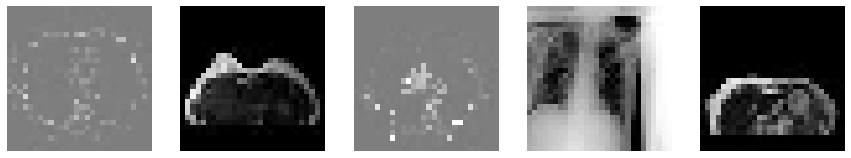

In [ ]:
n_examples = 500
example_images = test_data[0:n_examples]
example_labels = y_test[0:n_examples]
labels = [np.where(i==1)[0][0] for i in example_labels]

f, axs = plt.subplots(1, 5, figsize=(15, 4))
for j in range(len(axs)):
    axs[j].imshow(example_images[j+20])
    axs[j].axis('off')

## Modelo autoencoder

In [ ]:
encoded_dim = 2

encoder2 = Sequential([
    Conv2D(64,kernel_size = (3, 3), input_shape=(28,28,3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D( (2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(encoded_dim)
])

encoder2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 flatten_1 (Flatten)         (None, 784)              

In [ ]:
encoded_dim = 2

encoder = Sequential([
    Conv2D(64,kernel_size = (3, 3), input_shape=(28,28,3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D( (2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(encoded_dim)
])

encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 flatten (Flatten)           (None, 784)               0

## Reducción de dimensionalidad

In [ ]:
pretrain_encodings = encoder2(example_images).numpy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


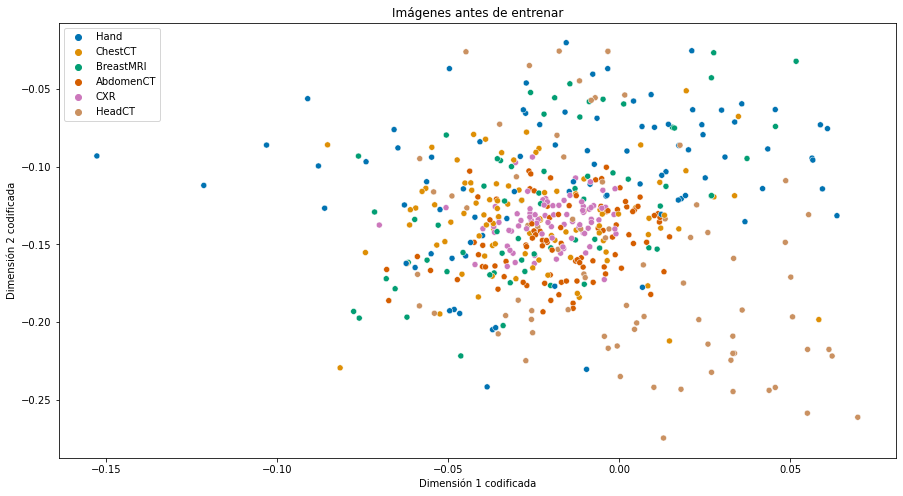

In [ ]:
class_names = np.array(['AbdomenCT', 'BreastMRI', 'ChestCT','CXR','Hand','HeadCT'])
f, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.scatterplot(pretrain_encodings[:, 0],
                pretrain_encodings[:, 1],
                hue=class_names[labels], ax=ax,
                palette=sns.color_palette("colorblind", 6));
ax.set_xlabel('Dimensión 1 codificada'); ax.set_ylabel('Dimensión 2 codificada')
ax.set_title('Imágenes antes de entrenar');

Para construir el decoder tenemos que basarnos en los parámetros que pusimos en el decoder, si vemos las últimas capas:

 conv2d_29 (Conv2D)          (None, 7, 7, 16)          4624      
                                                                 
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                 1570  

 Podemos hacer lo inverso, con una dense con 784, como tiene la aplanada anterior y llevándola a 7x7x16

In [ ]:
decoder = Sequential ([
    Dense(784, activation = 'relu', input_shape=(encoded_dim,)),
    Reshape((7,7,16)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3, (3, 3), padding='same') 
])

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 784)               2352      
                                                                 
 reshape (Reshape)           (None, 7, 7, 16)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                  

In [ ]:
autoencoder_dr = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))

autoencoder_dr.compile(loss = 'mse')

In [ ]:
autoencoder_dr.fit(train_data, train_data, epochs = 10, verbose=1)

Epoch 1/10
1474/1474 [==============================] - 31s 14ms/step - loss: 0.0288
Epoch 2/10
1474/1474 [==============================] - 18s 12ms/step - loss: 0.0216
Epoch 3/10
1474/1474 [==============================] - 18s 12ms/step - loss: 0.0202
Epoch 4/10
1474/1474 [==============================] - 18s 12ms/step - loss: 0.0195
Epoch 5/10
1474/1474 [==============================] - 18s 12ms/step - loss: 0.0190
Epoch 6/10
1474/1474 [==============================] - 18s 12ms/step - loss: 0.0187
Epoch 7/10
1474/1474 [==============================] - 18s 12ms/step - loss: 0.0184
Epoch 8/10
1474/1474 [==============================] - 18s 12ms/step - loss: 0.0183
Epoch 9/10
1474/1474 [==============================] - 18s 12ms/step - loss: 0.0181
Epoch 10/10
1474/1474 [==============================] - 18s 12ms/step - loss: 0.0180


In [ ]:
posttrain_encodings = encoder(example_images).numpy()

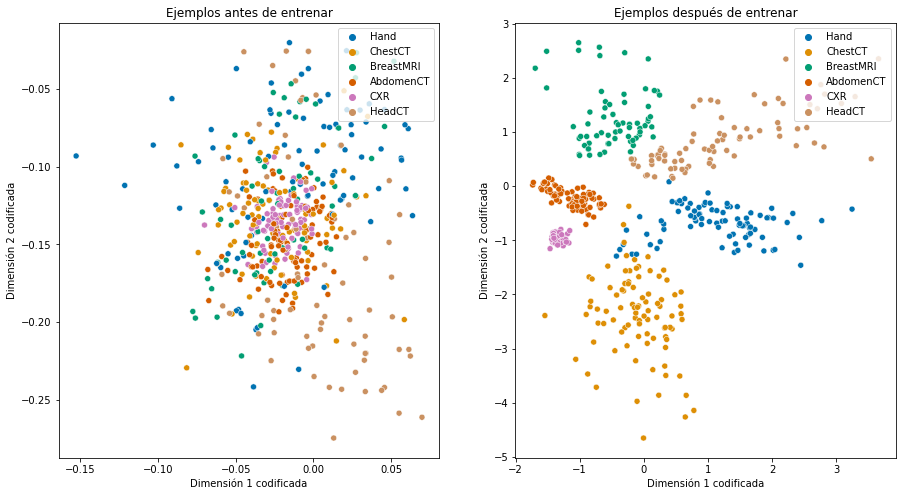

In [ ]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
sns.scatterplot(x=pretrain_encodings[:, 0],
                y=pretrain_encodings[:, 1],
                hue=class_names[labels], ax=axs[0],
                palette=sns.color_palette("colorblind", 6));
sns.scatterplot(x=posttrain_encodings[:, 0],
                y=posttrain_encodings[:, 1],
                hue=class_names[labels], ax=axs[1],
                palette=sns.color_palette("colorblind", 6));

axs[0].set_title('Ejemplos antes de entrenar');
axs[1].set_title('Ejemplos después de entrenar');

for ax in axs: 
    ax.set_xlabel('Dimensión 1 codificada')
    ax.set_ylabel('Dimensión 2 codificada')
    ax.legend(loc='upper right')

In [ ]:
reconstructed_img = autoencoder_dr(example_images)

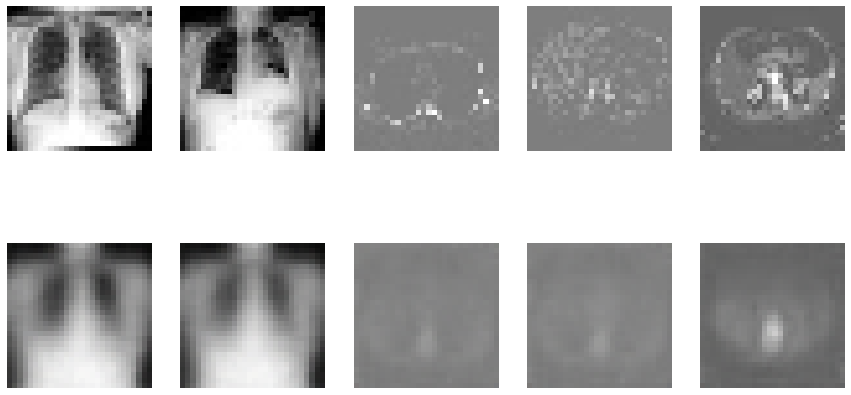

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
for j in range(5):
    axs[0, j].imshow(example_images[j+10], cmap='binary')
    axs[1, j].imshow(reconstructed_img[j+10].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')